<a href="https://colab.research.google.com/github/MouseLand/suite2p/blob/main/jupyter/run_suite2p_colab_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install suite2p

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 18.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 643 kB 5.4 MB/s 
     |████████████████████████████████| 80 kB 9.7 MB/s 
     |████████████████████████████████| 168 kB 47.6 MB/s 
     |████████████████████████████████| 212 kB 49.1 MB/s 
     |████████████████████████████████| 989 kB 42.2 MB/s 
     |████████████████████████████████| 995 kB 57.2 MB/s 
     |████████████████████████████████| 31.0 MB 1.3 MB/s 
     |████████████████████████████████| 4.2 MB 39.7 MB/s 
     |████████████████████████████████| 3.3 MB 31.9 MB/s 
     |████████████████████████████████| 3.3 MB 37.9 MB/s 
     |████████████████████████████████| 3.3 MB 31.4 MB/s 
     |████████████████████████████████| 3.3 MB 41.4 MB/s 
     |████████████████████████████████| 15.3 MB 12

In [1]:
import os, requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import suite2p

/home/stringlab/anaconda3/envs/suite2p/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [2]:
# Figure Style settings for notebook.
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': True,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

/tmp/ipykernel_560/1874460755.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  jet.set_bad(color='k')


# Running suite2p on example data

This notebook will guide you through the various stages and outputs of suite2p by running it on a real-life dataset. This is data collected from a wild-type mouse injected with GCaMP6s in primary visual cortex. The recording was collected at 13Hz (there were 3 planes in the recording, 1 is included here).

The next code cell downloads the data. You can also upload your own data to this folder on the left in the "Files" menu, or you can connect to your google drive (see instructions [here](https://colab.research.google.com/notebooks/io.ipynb)), which will make it easier to download the output files to your local computer.


In [3]:
fname = "gt1.tif"
url = "https://www.suite2p.org/test_data/gt1.tif"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

from tifffile import imread
data = imread(fname)
print('imaging data of shape: ', data.shape)
n_time, Ly, Lx = data.shape

imaging data of shape:  (4500, 325, 556)


## Set pipeline parameters

You can find an explanation of each op parameters [here](https://suite2p.readthedocs.io/en/latest/settings.html).

In [4]:
ops = suite2p.default_ops()
ops['batch_size'] = 200 # we will decrease the batch_size in case low RAM on computer
ops['threshold_scaling'] = 2.0 # we are increasing the threshold for finding ROIs to limit the number of non-cell ROIs found (sometimes useful in gcamp injections)
ops['fs'] = 13 # sampling rate of recording, determines binning for cell detection
ops['tau'] = 1.25 # timescale of gcamp to use for deconvolution
print(ops)

{'suite2p_version': '0.10.4.dev1+g53eae96', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': [], 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.25, 'fs': 13, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': 1, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 200, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames': True, 'force_refImg': False, 'pad_fft': 

## Set Data Path
`ops` and `db` are functionally equivalent internally in suite2p, with the exception that parameters provided in `db` will overwrite parameters specified in `ops`.

**Tip**:  Since it's common to change datasets and keep the same parameters for each dataset, some might find it useful to specify data-related arguments in `db` and pipeline parameters in `ops`. 

In [5]:
db = {
    'data_path': [os.getcwd()],
}
print(db)

{'data_path': ['/home/stringlab/Desktop/suite2p/jupyter']}


## Run Suite2p on Data

The `suite2p.run_s2p` function runs the pipeline and returns a list of output dictionaries containing the pipeline parameters used and extra data calculated along the way, one for each plane.

In [6]:
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': ['/home/stringlab/Desktop/suite2p/jupyter']}
FOUND BINARIES AND OPS IN ['/home/stringlab/Desktop/suite2p/jupyter/suite2p/plane0/ops.npy']
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: /home/stringlab/Desktop/suite2p/jupyter/suite2p/plane0/data.bin
NOTE: Applying builtin classifier at /home/stringlab/Desktop/suite2p/suite2p/classifiers/classifier.npy
----------- ROI DETECTION
Binning movie in chunks of length 16
Binned movie of size [281,319,552] created in 2.34 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 10.00 
0 ROIs, score=133.27
1000 ROIs, score=19.68
2000 ROIs, score=10.31
Detected 2116 ROIs, 20.50 sec
After removing overlaps, 2044 ROIs remain
----------- Total 25.49 sec.
----------- EXTRACTION
Masks created, 1.82 sec.
Extracted fluorescence from 2044 ROIs in 4500 frames, 10.13 sec.
----------- Total 12.13 sec.
----------- CLASSIFICATION
['skew', 'npix_norm', 'co

### Outputs from the Suite2p Pipeline

#### Ops dictionaries

The ops dictionary contains all the keys that went into the analysis, plus new keys that contain additional metrics/outputs calculated during the pipeline run.

In [7]:
print(set(output_ops.keys()).difference(ops.keys()))

{'reg_file', 'badframes', 'frames_per_folder', 'spatscale_pix', 'data_path', 'nframes', 'corrXY1', 'Lx', 'ihop', 'yrange', 'timing', 'Vcorr', 'xrange', 'meanImg', 'Vmap', 'xoff', 'meanImgE', 'Lxc', 'yoff1', 'Lyc', 'filelist', 'xoff1', 'save_path', 'Vmax', 'Ly', 'regPC', 'max_proj', 'rmin', 'regDX', 'Vsplit', 'refImg', 'yoff', 'input_format', 'first_tiffs', 'frames_per_file', 'ops_path', 'corrXY', 'date_proc', 'rmax', 'tPC'}


#### Results Files

In [8]:
list(Path(output_ops['save_path']).iterdir())

[PosixPath('/home/stringlab/Desktop/suite2p/jupyter/suite2p/plane0/iscell.npy'),
 PosixPath('/home/stringlab/Desktop/suite2p/jupyter/suite2p/plane0/Fneu.npy'),
 PosixPath('/home/stringlab/Desktop/suite2p/jupyter/suite2p/plane0/F.npy'),
 PosixPath('/home/stringlab/Desktop/suite2p/jupyter/suite2p/plane0/data.bin'),
 PosixPath('/home/stringlab/Desktop/suite2p/jupyter/suite2p/plane0/ops.npy'),
 PosixPath('/home/stringlab/Desktop/suite2p/jupyter/suite2p/plane0/stat.npy'),
 PosixPath('/home/stringlab/Desktop/suite2p/jupyter/suite2p/plane0/spks.npy')]

The output parameters can also be found in the "ops.npy" file.  This is especially useful when running the pipeline from the terminal or the graphical interface.  It contains the same data that is output from the python `run_s2p()` function.

In [9]:
output_ops_file = np.load(Path(output_ops['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_ops_file.keys() == output_ops.keys()

True

The other files will be used for the visualizations in the section below.

## Running individual Suite2P modules 
While `suite2p.run_s2p` runs the entire pipeline, you may instead want to run individual modules (e.g., registration, cell detection, extraction, etc.). In this section, we'll go over the steps to run the following individual modules.

1. Registration
2. ROI detection
3. Signal Extraction
4. Classification of ROIs
5. Spike Deconvolution

To run `registration`, `detection`, and `extraction` separately, we must first talk about a special class in `suite2p` called a `BinaryRWFile`. You can think of `BinaryRWFile` as a class for reading/writing image data that acts like a numpy array. 

### Running Registration 

To run registration alone (called by the `register.registration_wrapper` function in the registration module), we'll first instantiate the necessary parameters.

In [10]:
# Read in raw tif corresponding to our example tif
f_raw = suite2p.io.BinaryRWFile(Ly=Ly, Lx=Lx, filename=fname)
# Create a binary file we will write our registered image to
f_reg = suite2p.io.BinaryRWFile(Ly=Ly, Lx=Lx, filename='registered_data.bin')

We'll run the registration module only on our example image which only contains data from a single channel. You can add in data for the second channel (e.g., `f_reg_chan2` and `f_raw_chan2`) using similar code to what we have above. Refer to the docs to see what the outputs refer to.

In [11]:
refImg, rmin, rmax, meanImg, rigid_offsets, \
nonrigid_offsets, zest, meanImg_chan2, badframes, \
yrange, xrange = suite2p.registration_wrapper(f_reg, f_raw=f_raw, f_reg_chan2=None, 
                                                   f_raw_chan2=None, refImg=None, 
                                                   align_by_chan2=False, ops=ops)

Reference frame, 8.05 sec.
Registered 200/4501 in 2.55s
Registered 400/4501 in 5.23s
Registered 600/4501 in 7.89s
Registered 800/4501 in 10.58s
Registered 1000/4501 in 13.21s
Registered 1200/4501 in 15.93s
Registered 1400/4501 in 18.56s
Registered 1600/4501 in 21.22s
Registered 1800/4501 in 23.89s
Registered 2000/4501 in 26.68s
Registered 2200/4501 in 29.24s
Registered 2400/4501 in 31.78s
Registered 2600/4501 in 34.32s
Registered 2800/4501 in 36.90s
Registered 3000/4501 in 39.42s
Registered 3200/4501 in 42.01s
Registered 3400/4501 in 44.52s
Registered 3600/4501 in 47.13s
Registered 3800/4501 in 49.76s
Registered 4000/4501 in 52.36s
Registered 4200/4501 in 54.99s
Registered 4400/4501 in 57.63s
Registered 4501/4501 in 58.97s


### Running ROI Detection

To run ROI detection alone (called by the `detection_wrapper` function in the detection module), we'll first instantiate the necessary parameters. You only need a `BinaryRWFile` corresponding to a registered/unregistered recording. Here, we'll pass the `f_reg` we obtained after running the registration module above.

In [12]:
# Use default classification file provided by suite2p 
classfile = suite2p.classification.builtin_classfile

In [13]:
ops, stat = suite2p.detection_wrapper(f_reg=f_reg, ops=ops, classfile=classfile)

Binning movie in chunks of length 16
Binned movie of size [281,325,556] created in 2.36 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 10.00 
0 ROIs, score=127.19
1000 ROIs, score=27.56
2000 ROIs, score=21.74
3000 ROIs, score=17.57
4000 ROIs, score=13.39
Detected 5000 ROIs, 30.68 sec
After removing overlaps, 4600 ROIs remain


### Running Fluorescence Extraction
To run extraction alone (called by the `extraction_wrapper` function in the extraction module), we can just make use of any `stat` dictionary (from previous runs of suite2p or a custom user-made one). In this case, we'll use the one output by the cell above. If you'd like to extract signal, you can pass a `binaryRWFile` corresponding to the recording for the second channel to the `f_reg_chan2` parameter.

In [14]:
stat_after_extraction, F, Fneu, F_chan2, Fneu_chan2 = suite2p.extraction_wrapper(stat, f_reg,
                                                                   f_reg_chan2 = None,ops=ops)


Masks created, 3.25 sec.
Extracted fluorescence from 4600 ROIs in 4501 frames, 10.13 sec.


### Running Cell classification
To run cell classification(called by the `classify` function in the classification module), we just need a `stat` dictionary and `classfile`. 

**Important**: The `stat` dictionary used in the classification module should not be the same as the one used in extraction. The `stat` used for classification requires a few more keys which are added after the extraction step. 

We'll use `stat_after_extraction` from the output of the extraction cell above and the same `classfile` used above.

In [15]:
iscell = suite2p.classify(stat=stat_after_extraction, classfile=classfile)

['skew', 'npix_norm', 'compact']


### Running Spike Deconvolution

To run spike deconvolution (called by the `oasis` function in the extraction module), we need to first run the preprocess step. To do so, we'll need `dF` which consist of the fluorescence traces for our cells after neuropil correction.

In [16]:
# Correct our fluorescence traces 
dF = F.copy() - ops['neucoeff']*Fneu

In [17]:
# Apply preprocessing step for deconvolution
dF = suite2p.extraction.preprocess(
        F=dF,
        baseline=ops['baseline'],
        win_baseline=ops['win_baseline'],
        sig_baseline=ops['sig_baseline'],
        fs=ops['fs'],
        prctile_baseline=ops['prctile_baseline']
    )
# Identify spikes
spks = suite2p.extraction.oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])


## Visualizations

### Registration

Registration computes a reference image from a subset of frames and registers all frames to the reference. 

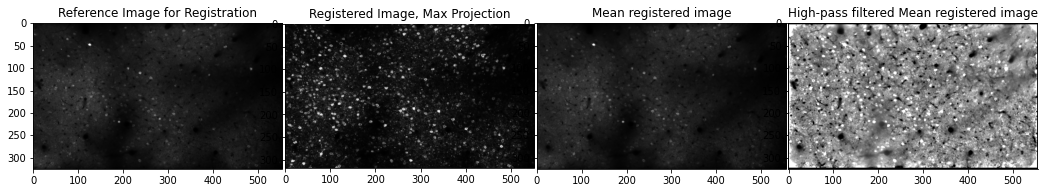

In [ ]:
plt.subplot(1, 4, 1)

plt.imshow(output_ops['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

# maximum of recording over time
plt.subplot(1, 4, 2)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(1, 4, 3)
plt.imshow(output_ops['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(1, 4, 4)
plt.imshow(output_ops['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

The rigid offsets of the frame from the reference are saved in `output_ops['yoff']` and `output_ops['xoff']`. The nonrigid offsets are saved in `output_ops['yoff1']` and `output_ops['xoff1']`, and each column is the offsets for a block (128 x 128 pixels by default).

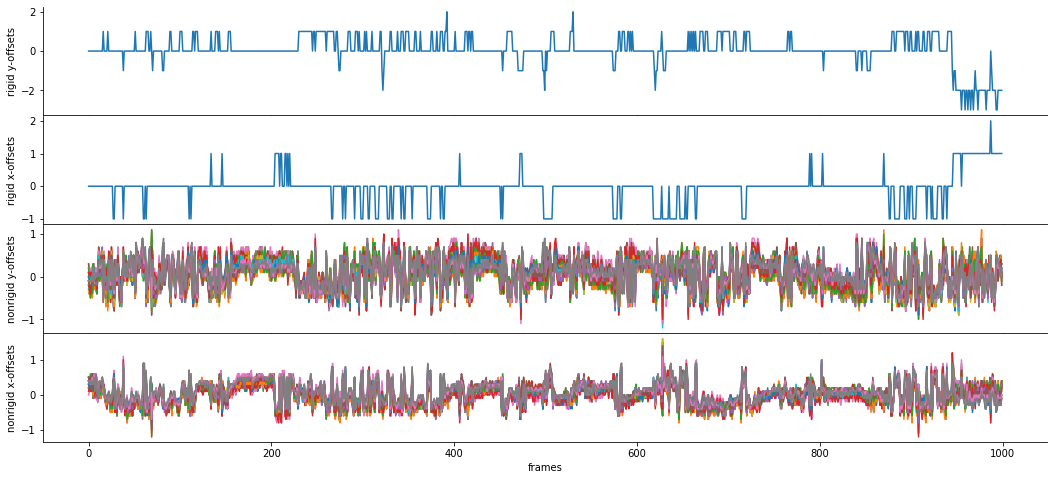

In [ ]:
plt.figure(figsize=(18,8))

plt.subplot(4,1,1)
plt.plot(output_ops['yoff'][:1000])
plt.ylabel('rigid y-offsets')

plt.subplot(4,1,2)
plt.plot(output_ops['xoff'][:1000])
plt.ylabel('rigid x-offsets')

plt.subplot(4,1,3)
plt.plot(output_ops['yoff1'][:1000])
plt.ylabel('nonrigid y-offsets')

plt.subplot(4,1,4)
plt.plot(output_ops['xoff1'][:1000])
plt.ylabel('nonrigid x-offsets')
plt.xlabel('frames')

plt.show()


In [ ]:
#@title Run cell to look at registered frames
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from suite2p.io import BinaryFile

widget = widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


def plot_frame(t):
    with BinaryFile(Ly=output_ops['Ly'],
                Lx=output_ops['Lx'],
                read_filename=output_ops['reg_file']) as f:
        plt.imshow(f[t][0])

interact(plot_frame, t=(0, output_ops['nframes'], 1));

interactive(children=(IntSlider(value=2250, description='t', max=4500), Output()), _dom_classes=('widget-inter…

Here in the notebook is not the best/fastest way to play the movie, you can play it in the suite2p GUI in the "View registered binary" player.

### Detection

ROIs are found by searching for sparse signals that are correlated spatially in the FOV. The ROIs are saved in `stat.npy` as a list of dictionaries which contain the pixels of the ROI and their weights (`stat['ypix']`, `stat['xpix']`, and `stat['lam']`). It also contains other spatial properties of the ROIs such as their aspect ratio and compactness, and properties of the signal such as the skewness of the fluorescence signal.


In [ ]:
stats_file = Path(output_ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(int)
stats = np.load(stats_file, allow_pickle=True)
print(stats[0].keys())

dict_keys(['ypix', 'xpix', 'lam', 'med', 'footprint', 'mrs', 'mrs0', 'compact', 'solidity', 'npix', 'npix_soma', 'soma_crop', 'overlap', 'radius', 'aspect_ratio', 'npix_norm_no_crop', 'npix_norm', 'skew', 'std', 'neuropil_mask'])


Some ROIs are defined as "cells" (somatic ROIs) or "not cells" (all other ROIs) depending on their properties, like skewness, compactness, etc. Below we will visualize the ROIs, but please open the files in the suite2p GUI for closer inspection.

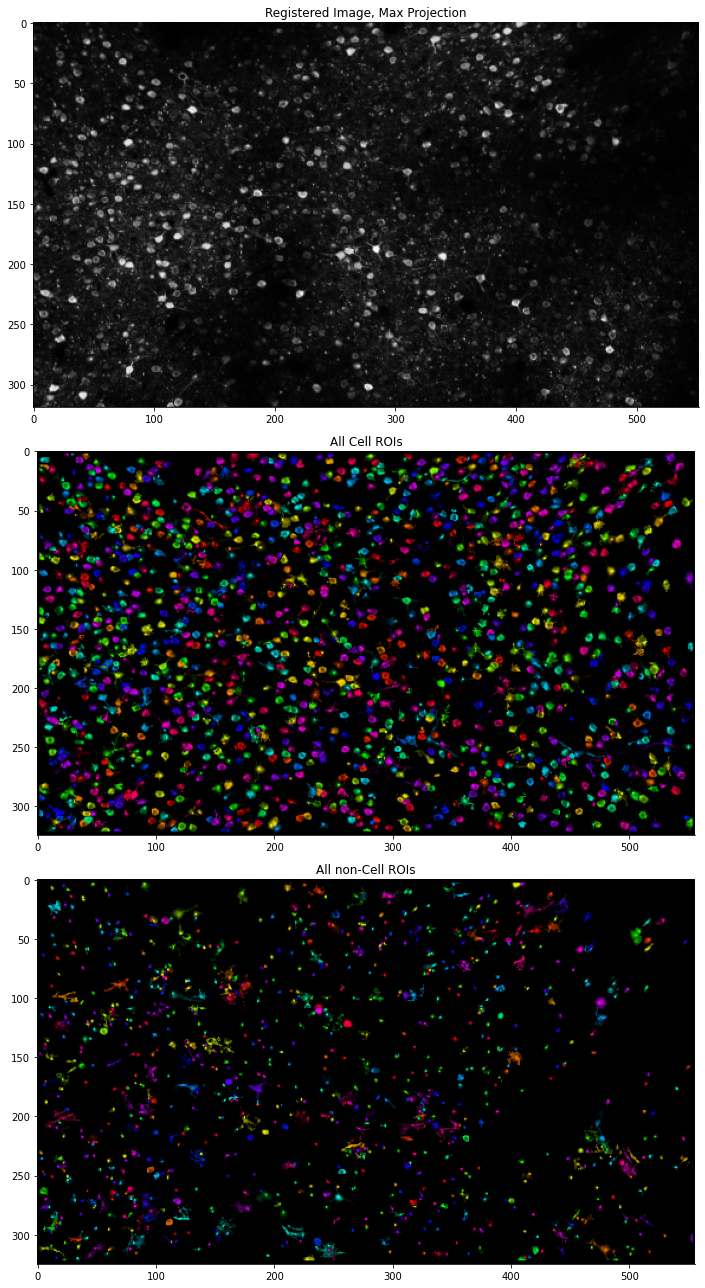

In [ ]:
n_cells = len(stats)

h = np.random.rand(n_cells)
hsvs = np.zeros((2, Ly, Lx, 3), dtype=np.float32)

for i, stat in enumerate(stats):
    ypix, xpix, lam = stat['ypix'], stat['xpix'], stat['lam']
    hsvs[iscell[i], ypix, xpix, 0] = h[i]
    hsvs[iscell[i], ypix, xpix, 1] = 1
    hsvs[iscell[i], ypix, xpix, 2] = lam / lam.max()

from colorsys import hsv_to_rgb
rgbs = np.array([hsv_to_rgb(*hsv) for hsv in hsvs.reshape(-1, 3)]).reshape(hsvs.shape)

plt.figure(figsize=(18,18))
plt.subplot(3, 1, 1)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(3, 1, 2)
plt.imshow(rgbs[1])
plt.title("All Cell ROIs")

plt.subplot(3, 1, 3)
plt.imshow(rgbs[0])
plt.title("All non-Cell ROIs");

plt.tight_layout()

### Traces

We will load in the fluorescence, the neuropil and the deconvolved traces, and visualize them for a few cells.

In [ ]:
f_cells = np.load(Path(output_ops['save_path']).joinpath('F.npy'))
f_neuropils = np.load(Path(output_ops['save_path']).joinpath('Fneu.npy'))
spks = np.load(Path(output_ops['save_path']).joinpath('spks.npy'))
f_cells.shape, f_neuropils.shape, spks.shape

((2372, 4500), (2372, 4500), (2372, 4500))

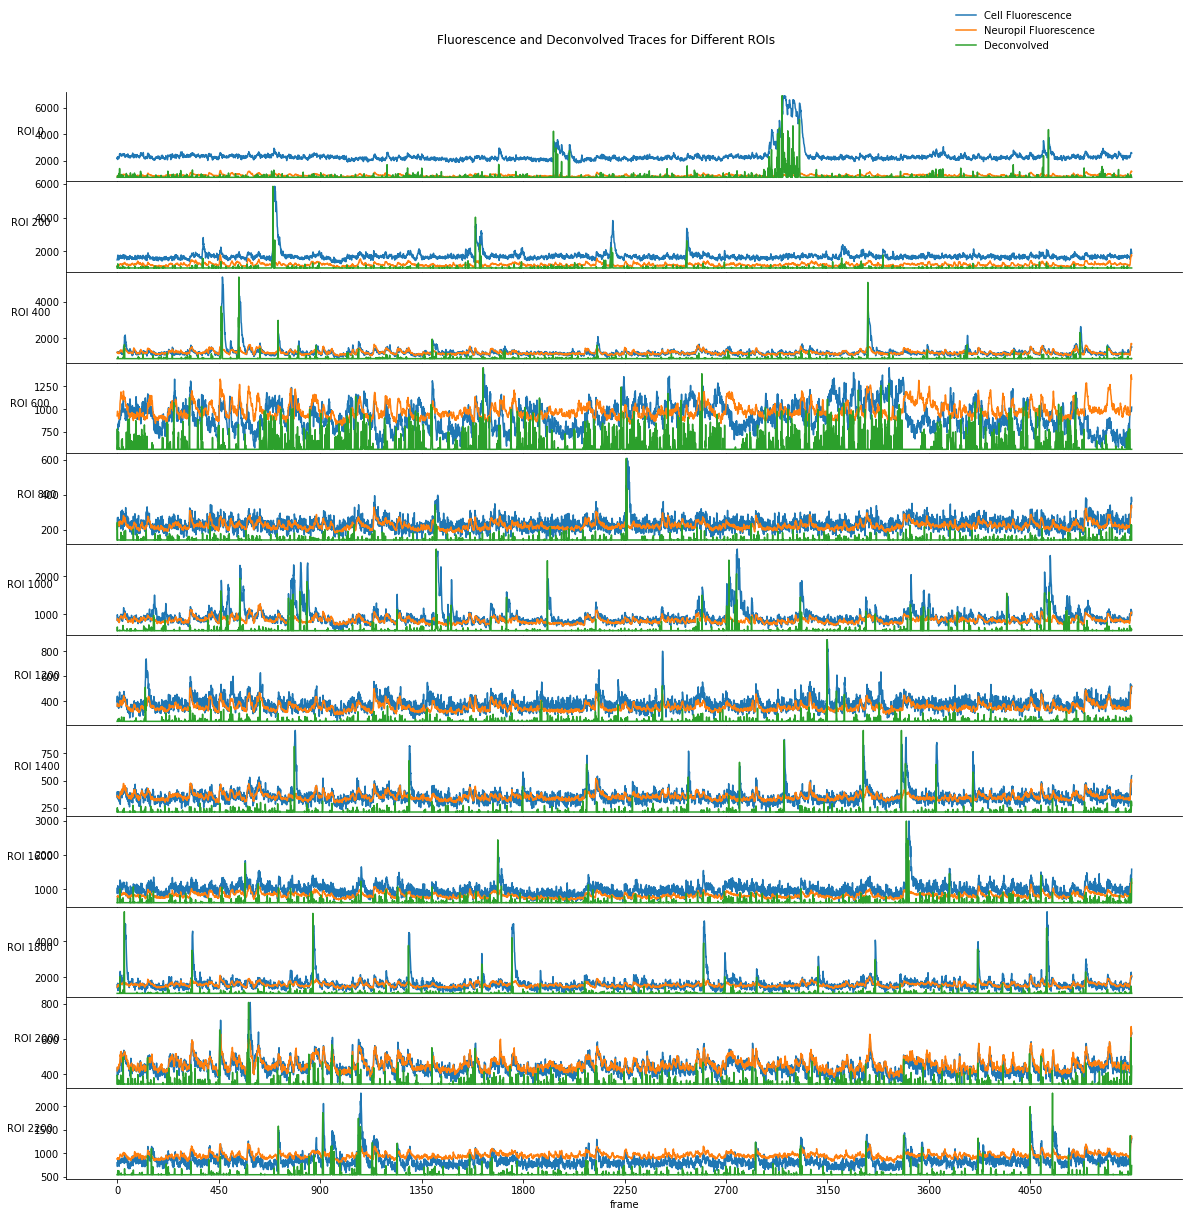

In [ ]:
plt.figure(figsize=[20,20])
plt.suptitle("Fluorescence and Deconvolved Traces for Different ROIs", y=0.92);
rois = np.arange(len(f_cells))[::200]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    f = f_cells[roi]
    f_neu = f_neuropils[roi]
    sp = spks[roi]
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin 
    sp /= sp.max()
    sp *= frange
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
    plt.xticks(np.arange(0, f_cells.shape[1], f_cells.shape[1]/10))
    plt.ylabel(f"ROI {roi}", rotation=0)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(0.93, 2))